In [ ]:
#This notebook is designed to make an ROI selection based on a threshold cut to benchmark the
#CNN performance.
#Ideas:
#Benchmark NN against threshold cut of 3,4,5 noise sigma above 0.
#Make a selection notebook that does this
#Make it even fancier by creating an ROI by finding peak at X sigma then tracing down 
#left and right continuously until below 2 sigma or something.

In [1]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load memory-mapped files
noise_memmap = np.memmap("noise.raw", dtype=np.float32, mode='r', shape=(1000, 1280, 2128))
signal_memmap = np.memmap("signal.raw", dtype=np.float32, mode='r', shape=(1000, 1280, 2128))
roi_memmap = np.load("roi.npy")  # True ROI labels

# Extract only TPC 0 Plane Z (channels 800-1039)
noise_data = noise_memmap[:, 800:1040, :]
signal_data = signal_memmap[:, 800:1040, :]
roi_true = roi_memmap[:, 800:1040, :]

# Compute noise statistics (mean and standard deviation)
noise_mean = np.mean(noise_data - signal_data)
noise_std = np.std(noise_data - signal_data)

# Set threshold values
#These are tunable
s_high = noise_mean + 5 * noise_std
s_low = noise_mean + 2 * noise_std

# Define function to find ROI
def traditional_roi_finder(waveforms, s_high, s_low):
    """Identify ROI regions using thresholding method."""
    roi_pred = np.zeros_like(waveforms, dtype=np.uint8)
    
    for i in range(waveforms.shape[0]):  # Loop over events
        for j in range(waveforms.shape[1]):  # Loop over channels
            waveform = waveforms[i, j]
            peak_indices = np.where(waveform > s_high)[0] #Assume there is only one peak
            
            if len(peak_indices) > 0:
                start = peak_indices[0]
                end = peak_indices[-1]
                
                while start > 0 and waveform[start] > s_low:
                    start -= 1
                while end < len(waveform) - 1 and waveform[end] > s_low:
                    end += 1
                
                roi_pred[i, j, start:end+1] = 1
    
    return roi_pred

# Apply traditional ROI finder
roi_pred = traditional_roi_finder(signal_data, s_high, s_low)
np.save("roi_pred_trad.npy",roi_pred)

# Flatten for metric calculation
y_true = roi_true.flatten()
y_pred = roi_pred.flatten()

# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print results
print(f"Traditional ROI Finder Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

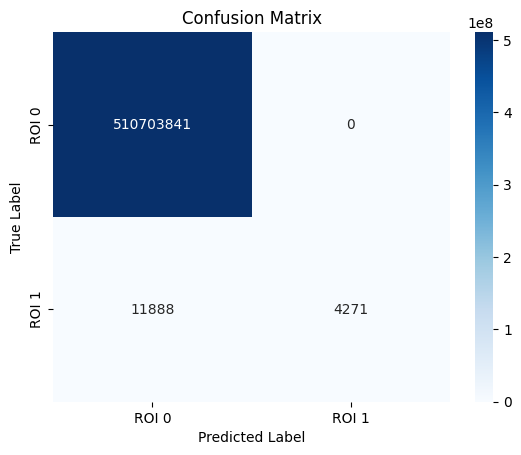

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["ROI 0", "ROI 1"], yticklabels=["ROI 0", "ROI 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [4]:
roi_pred = np.load("roi_pred_trad.npy")  # Predicted ROI from traditional algorithm
print(np.shape(roi_pred))

(1000, 240, 2128)


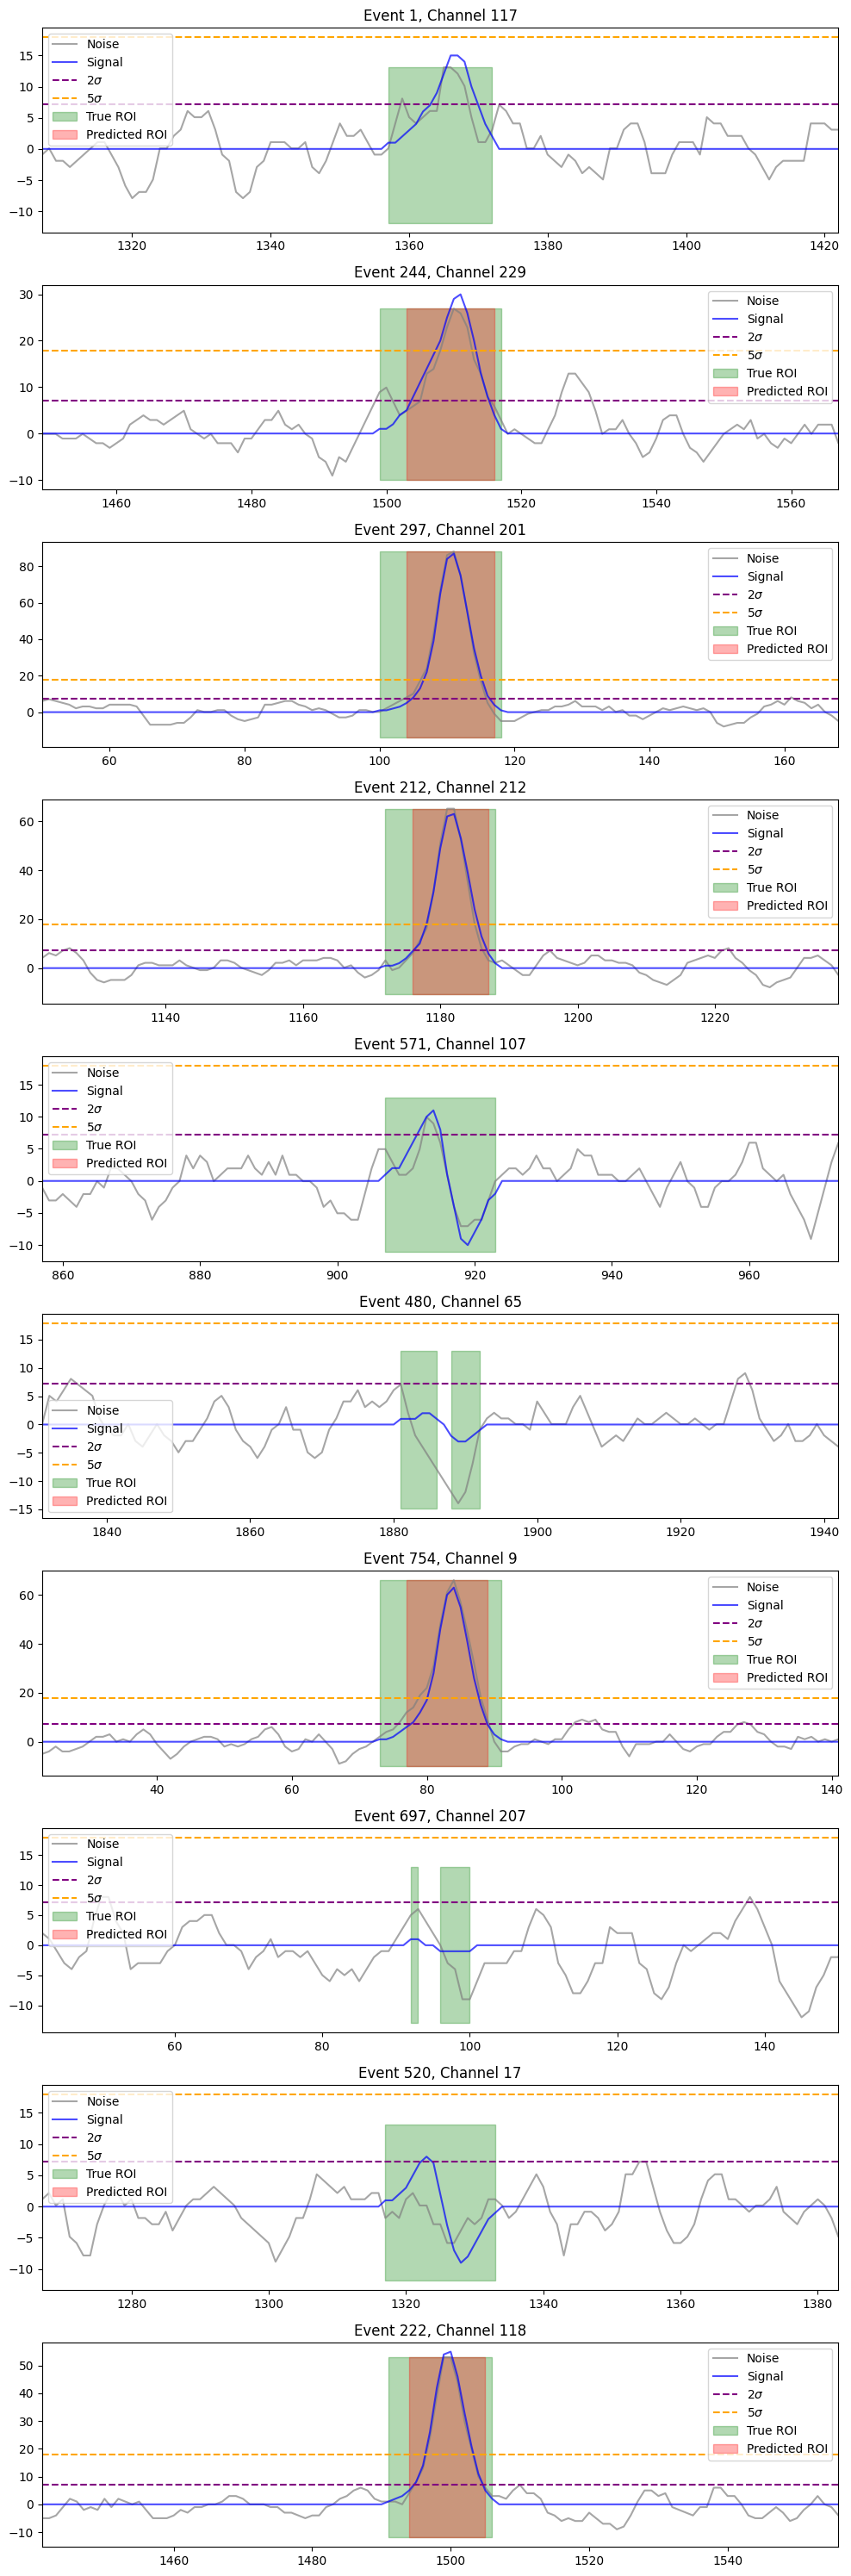

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Load memmap files
noise_memmap = np.memmap("noise.raw", dtype=np.float32, mode='r', shape=(1000, 1280, 2128))
signal_memmap = np.memmap("signal.raw", dtype=np.float32, mode='r', shape=(1000, 1280, 2128))
roi_memmap = np.load("roi.npy")  # True ROI
roi_pred = np.load("roi_pred_trad.npy")  # Predicted ROI from traditional algorithm

# Extract TPC 0 Plane Z
noise_data = noise_memmap[:, 800:1040, :]
signal_data = signal_memmap[:, 800:1040, :]
roi_data = roi_memmap[:, 800:1040, :]
roi_pred_data = roi_pred #[:, 800:1040, :] -- roi_pred is already just TPC 0 Plane Z

# Compute noise statistics (mean and standard deviation)
noise_mean = np.mean(noise_data - signal_data)
noise_std = np.std(noise_data - signal_data)

# Find indices where true ROI is nonzero
valid_indices = np.argwhere(roi_data.sum(axis=2) > 0)  # Get (event_idx, ch_idx) where ROI exists

# Select a few random waveforms from the valid ones
num_samples = 10
selected_indices = random.sample(list(valid_indices), min(num_samples, len(valid_indices)))

fig, axes = plt.subplots(len(selected_indices), 1, figsize=(10, 3 * len(selected_indices)))

for i, (event_idx, ch_idx) in enumerate(selected_indices):
    noise_waveform = noise_data[event_idx, ch_idx, :]
    signal_waveform = signal_data[event_idx, ch_idx, :]
    true_roi = roi_data[event_idx, ch_idx, :]
    predicted_roi = roi_pred_data[event_idx, ch_idx, :]

    ax = axes[i] if len(selected_indices) > 1 else axes
    ax.set_xlim(np.where(true_roi)[0][0] -50, np.where(true_roi)[0][-1] +50)
    ax.plot(noise_waveform, color='gray', alpha=0.7, label="Noise")
    ax.plot(signal_waveform, color='blue', alpha=0.7, label="Signal")

    #Add horiztonal lines for 2 sigma and 5 sigma
    ax.axhline(noise_mean + 2* noise_std, color='purple', linestyle='dashed', label=r'$2\sigma$')
    ax.axhline(noise_mean + 5* noise_std, color='orange', linestyle='dashed', label=r'$5\sigma$')
    
    # Shade True ROI
    ax.fill_between(range(len(true_roi)), min(noise_waveform), max(noise_waveform),
                    where=true_roi > 0, color='green', alpha=0.3, label="True ROI")
    
    # Shade Predicted ROI
    ax.fill_between(range(len(predicted_roi)), min(noise_waveform), max(noise_waveform),
                    where=predicted_roi > 0, color='red', alpha=0.3, label="Predicted ROI")
    
    ax.set_title(f"Event {event_idx}, Channel {ch_idx}")
    ax.legend()

plt.tight_layout()
plt.show()

357
295


/tmp/ipykernel_2744/3395923593.py:16: RuntimeWarning: invalid value encountered in divide
  Ratio = np.divide(Pred_Ar39_Fraction,True_Ar39_Fraction)


357
295


(array([ 2.,  0.,  0.,  1.,  1.,  1.,  3.,  0., 13.,  3., 10.,  3., 10.,
        17.,  0.,  0., 29.,  0., 57.,  3., 11., 43.,  2., 36., 34.,  0.,
        12.,  0.,  3.,  1.]),
 array([0.53333333, 0.54148148, 0.54962963, 0.55777778, 0.56592593,
        0.57407407, 0.58222222, 0.59037037, 0.59851852, 0.60666667,
        0.61481481, 0.62296296, 0.63111111, 0.63925926, 0.64740741,
        0.65555556, 0.6637037 , 0.67185185, 0.68      , 0.68814815,
        0.6962963 , 0.70444444, 0.71259259, 0.72074074, 0.72888889,
        0.73703704, 0.74518519, 0.75333333, 0.76148148, 0.76962963,
        0.77777778]),
 <BarContainer object of 30 artists>)

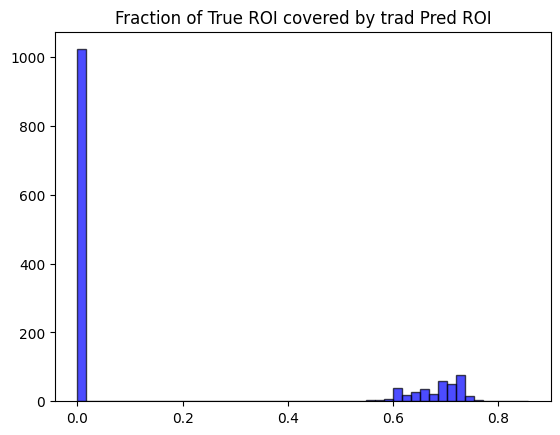

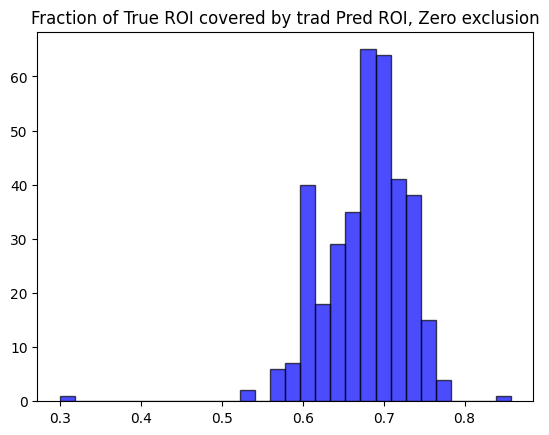

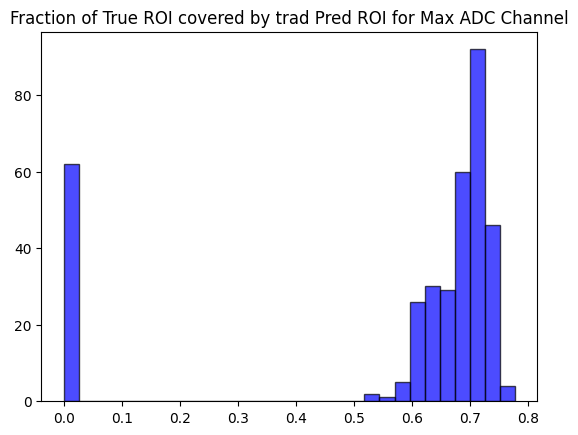

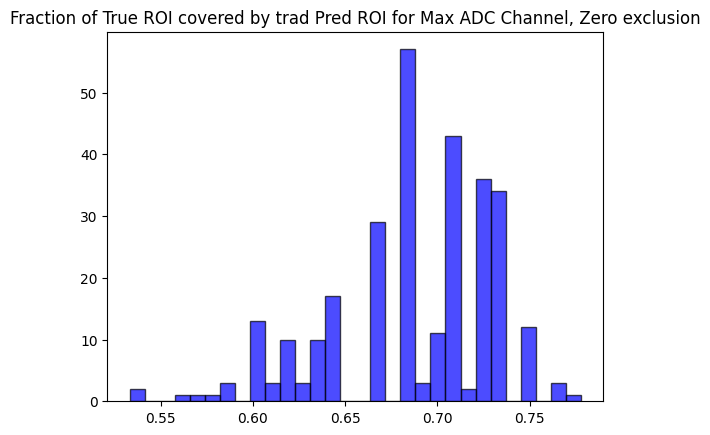

In [27]:
#In how many events with a true ROI do we identify any predicted ROI?
True_Ar39_Events = np.any(roi_data,axis=(1,2))
Pred_Ar39_Events = np.any(roi_pred_data,axis=(1,2))

countTrue = np.sum(True_Ar39_Events)
countPred = np.sum(Pred_Ar39_Events)

print(countTrue)
print(countPred)

#Ok... now plot the distributions of the fractions of the ROI covered
#We know there is no pred ROI where there is no true ROI, so that simplifies calculation because one is a subset of the other
True_Ar39_Fraction = np.sum(roi_data,axis=2)
Pred_Ar39_Fraction = np.sum(roi_pred_data,axis=2)

Ratio = np.divide(Pred_Ar39_Fraction,True_Ar39_Fraction)
Ratio_flatten = Ratio.flatten()
Ratio_sanitized = Ratio_flatten[np.isfinite(Ratio_flatten)]

#Let's plot the fractions of ROI covered just for the MaxADCChannel
#signal_data = signal_memmap[:, 800:1040, :]
max_adc_per_channel = np.max(signal_data, axis=2)

# Find the index of the channel with the maximum ADC value for each event (axis 1)
max_adc_channels = np.argmax(max_adc_per_channel, axis=1)

# max_adc_channels now holds the index of the channel with the max ADC value for each event
#print(max_adc_channels)

Ratio_Best = []
for iEvent in range(1000):
    if np.max(signal_data[iEvent]) > 0:
        Ratio_Best.append(Ratio[iEvent][max_adc_channels[iEvent]])
Ratio_Best = np.array(Ratio_Best)
print(len(Ratio_Best))
print(len(Ratio_Best[Ratio_Best > 0]))

plt.figure()
plt.title("Fraction of True ROI covered by trad Pred ROI")
plt.hist(Ratio_sanitized, bins=50, alpha=0.7, color='b', edgecolor='black')

plt.figure()
plt.title("Fraction of True ROI covered by trad Pred ROI, Zero exclusion")
plt.hist(Ratio_sanitized[Ratio_sanitized > 0], bins=30, alpha=0.7, color='b', edgecolor='black')

plt.figure()
plt.title("Fraction of True ROI covered by trad Pred ROI for Max ADC Channel")
plt.hist(Ratio_Best, bins=30, alpha=0.7, color='b', edgecolor='black')

plt.figure()
plt.title("Fraction of True ROI covered by trad Pred ROI for Max ADC Channel, Zero exclusion")
plt.hist(Ratio_Best[Ratio_Best > 0], bins=30, alpha=0.7, color='b', edgecolor='black')



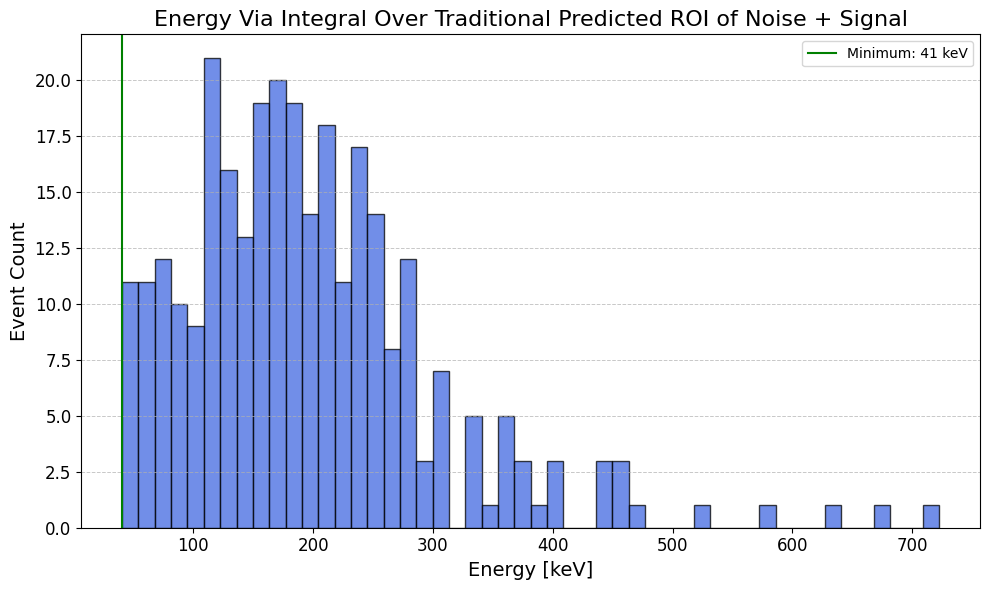

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Load the traditional predicted ROI and noise+signal data
roi_path = 'roi_pred_trad.npy'
noise_signal_path = 'noise.raw'

# Load ROI (shape: (1000, 240, 2128))
roi = np.load(roi_path)

# Load noise+signal using memmap (shape: (1000, 240, 2128))
noise_memmap = np.memmap(noise_signal_path, dtype=np.float32, mode='r', shape=(1000, 1280, 2128))
noise_signal = noise_memmap[:, 800:1040, :]

# Validate that both arrays have the same shape
assert roi.shape == noise_signal.shape, "Shape mismatch between ROI and noise+signal arrays."

# Compute the weighted integral for each event
# Multiply noise+signal by the ROI mask and sum over the wire (axis=2) and channels (axis=1)
weighted_integrals = np.sum(noise_signal * roi, axis=(1, 2))

weighted_integrals=weighted_integrals[weighted_integrals>0]

scale_factor = 170/333 #keV/ADC*timetick, matching peak of Ar39 spectrum to peak of integral spectrum
weighted_integrals *= scale_factor

min_energy = np.min(weighted_integrals)

# Create a presentation-quality histogram
plt.figure(figsize=(10, 6))
plt.hist(weighted_integrals, bins=50, color='royalblue', edgecolor='black', alpha=0.75)
plt.axvline(min_energy, color='g', linestyle='solid', label='Minimum: '+str(round(min_energy))+' keV')

# Set axis labels and title
plt.xlabel('Energy [keV]', fontsize=14)
plt.ylabel('Event Count', fontsize=14)
#plt.title('Integral Over Traditional Predicted ROI of Noise + Signal', fontsize=16)
plt.title('Energy Via Integral Over Traditional Predicted ROI of Simulated Noise + Signal', fontsize=16)

# Improve tick formatting
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.0f}'))
plt.tick_params(axis='both', which='major', labelsize=12)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Display the histogram
plt.legend()
plt.tight_layout()
plt.show()